Creating dataset and dataloaders

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path
import cv2
from PIL import Image
import numpy as np
import os
import albumentations as A
from torchvision.transforms import *
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch

class VascularDataset(Dataset):
    """
    Dataset class for the vascular dataset:
    """
    def __init__(self,
                 folder_path,
                 transform=None):
        super(VascularDataset, self).__init__()
        self.folder_path=folder_path
        self.images = self.build_dataset()
        self.mean_normalization=(0.485, 0.456, 0.406)
        self.std_normalization=(0.229, 0.224, 0.225)
        self.totensor=ToTensor()
        self.resize=Compose([Resize(224)])

    def build_dataset(self):
        #imgs = sorted(Path(self.folder_path).glob("**/[!*seg*]*.png"))
        imgs = [path for path in sorted(Path(self.folder_path).glob("**/*.png")) if 'seg' not in str(path).split('/')[-1]]
        return imgs

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):

        img_path = str(self.images[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=self.resize(Image.fromarray(img))
        img=self.totensor(img)

        if 'crop' in img_path:
          seg_path = img_path.replace('crop', 'seg_crop')
          
          try:
              seg = Image.open(seg_path)
          except FileNotFoundError:
            try:
              seg_path=seg_path.replace('seg_crop','segmentation_crop')
              seg = Image.open(seg_path)
            except FileNotFoundError:
              seg_path=seg_path.replace('segmentation_crop','segmentation-crop')
              seg = Image.open(seg_path)
        else:
          seg_path=img_path.replace('img','seg')
          seg = Image.open(seg_path)

        seg = seg.convert('RGB')    # remove the transparent portion of the image
        seg = seg.convert('L')      # from RGB to black and white
        seg=self.resize(seg)      
        seg = seg.point(lambda x: 0 if x < 1 else 255.0, '1')
        seg = np.array(seg, dtype=np.float32)  # equivalent to a cv2 image
        seg = np.expand_dims(seg, axis=0)
        '''
        if self.transform:
            transformed = self.transform(image=img, mask=seg)
            img = transformed['image']
            seg = transformed['mask']
        '''
        return img, seg

def connect_to_drive():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

def split_dataset_into_train_and_valid(dataset, percentage_train):
  lengths = [int(len(dataset)*percentage_train), len(dataset)-int(len(dataset)*percentage_train)]
  train_dataset, valid_dataset = random_split(dataset, lengths)
  return train_dataset, valid_dataset


connect_to_drive()

import random
torch.manual_seed(0)
random.seed(0)

input_path_training='/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train'
training_dataset=VascularDataset(input_path_training)

input_path_test='/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Test'
test_dataset=VascularDataset(input_path_test)

save_model_folder='/content/gdrive/'

percentage_train=0.8
train_dataset, valid_dataset=split_dataset_into_train_and_valid(training_dataset, percentage_train)

batch_size=32

print(f'Training dataset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(valid_dataset)}')
print(f'Test dataset length: {len(test_dataset)}')

train_dataloader=DataLoader(train_dataset, batch_size=batch_size,num_workers=1, shuffle=True, pin_memory=True)
valid_dataloader=DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_dataloader=DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Mounted at /content/gdrive
Training dataset length: 160
Validation dataset length: 40
Test dataset length: 10


Initializing Wandb and defining hyperparameters

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
#import collections.abc as container_abcs

!pip install wandb
import wandb
wandb.init(project="2")

from torch.optim.lr_scheduler import StepLR

def register_wandb_config(model_type, n_epochs, lr_config, encoder_type, optimizer_config, step_size, gamma, number_of_crops_each_image):
  wandb.config.model_type = model_type
  wandb.config.epochs = n_epochs
  wandb.config.learning_rate = lr_config
  wandb.config.encoder = encoder_type
  wandb.config.optimizer = optimizer_config
  wandb.config.step_size = step_size
  wandb.config.gamma = gamma
  wandb.config.number_of_crops_each_image = number_of_crops_each_image

lr_config=0.5
optimizer_config = 'SGD'
n_epochs=50
encoder_type='resnet18'
model_type='Unet'
step_size=5
gamma=0.1
number_of_crops_each_image=1

save_model_path='/content/gdrive/MyDrive/Saved_models/'+model_type+'/'+wandb.run.name
print(f'Path for model saving: {save_model_path}')

register_wandb_config(model_type, n_epochs, lr_config, encoder_type, optimizer_config, step_size, gamma, number_of_crops_each_image)

training loss,0.0199
_runtime,119
_timestamp,1625419646
_step,11
training iou,0.00131
validation loss,57716.43125
validation iou,0.0


training loss,█▁▁
_runtime,▁▁▂▂▄▄▅▅▇▇██
_timestamp,▁▁▂▂▄▄▅▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█
training iou,█▁▁
validation loss,█▁▁
validation iou,▁▁▁


Path for model saving: /content/gdrive/MyDrive/Saved_models/Unet/lucky-valley-7


Initializing model, optimizers, schedulers, metrics, loss, defining saving folder

---



In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

model = smp.Unet(
    encoder_name=encoder_type,       
    encoder_weights="imagenet", 
    in_channels=3,                 
    classes=1,
)

model.cuda()
optimizer = SGD(model.parameters(), lr=lr_config, momentum=0.9)
loss=torch.nn.BCEWithLogitsLoss()


def iou_numpy(outputs: np.array, labels: np.array):
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou_score = torch.sum(intersection) / torch.sum(union)
    return iou_score 

print(f'Using GPU {torch.cuda.get_device_name(0)}')

one=torch.ones(size=(3,1)).cuda()
print(one.device)

Using GPU Tesla T4
cuda:0


Training, validation, saving model

In [ ]:
from tqdm import tqdm

lowest_validation_loss=9999

for epoch in range(1, n_epochs+1, 1):

  #Training phase
  model.train()
  training_loss=0
  training_iou=0
  training_samples=0

  for x,y in tqdm(train_dataloader): 
    optimizer.zero_grad()
    out=model(x.cuda())
    myloss=loss(out, y.cuda())

    for out_i,y_i in zip(out,y.cuda()):
      iou=iou_numpy(out_i>0,y_i)
      training_iou+=iou
      training_samples+=1

    myloss.backward()
    optimizer.step()
    training_loss+=myloss.item()
  
  print(f'Epoch #{epoch}, training loss: {training_loss/training_samples}, training iou: {training_iou/training_samples}')

  wandb.log({"training loss": training_loss/training_samples})
  wandb.log({"training iou": training_iou/training_samples})

  #Validation phase
  model.eval()
  validation_loss=0
  validation_iou=0
  validation_samples=0

  for x,y in tqdm(valid_dataloader): 
    out=model(x.cuda())
    myloss=loss(out, y.cuda())

    for out_i,y_i in zip(out,y.cuda()):
      iou=iou_numpy(out_i>0,y_i)
      validation_iou+=iou
      validation_samples+=1

    validation_loss+=myloss.item()

  print(f'Epoch #{epoch}, validation loss: {validation_loss/validation_samples}, validation iou: {validation_iou/validation_samples}')

  if validation_loss/validation_samples<lowest_validation_loss:
    lowest_validation_loss=validation_loss/validation_samples
    torch.save(model,f'{save_model_path}.pth')
    last_epoch_saved=epoch
    
  wandb.log({"validation loss": validation_loss/validation_samples})
  wandb.log({"validation iou": validation_iou/validation_samples})

print(f'Last epoch saved: {last_epoch_saved}')




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.56s/it]

 40%|████      | 2/5 [00:10<00:22,  7.48s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.16s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.80s/it]

100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #1, training loss: 0.021421968191862106, training iou: 0.08509716391563416




 50%|█████     | 1/2 [00:07<00:07,  7.15s/it]

100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


Epoch #1, validation loss: 0.030112726986408232, validation iou: 6.120959733380005e-05




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.59s/it]

 40%|████      | 2/5 [00:10<00:22,  7.51s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.20s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.82s/it]

100%|██████████| 5/5 [00:28<00:00,  5.62s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #2, training loss: 0.018966682627797125, training iou: 0.02610003761947155




 50%|█████     | 1/2 [00:07<00:07,  7.23s/it]

100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Epoch #2, validation loss: 0.029246866703033447, validation iou: 0.019018081948161125




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.64s/it]

 40%|████      | 2/5 [00:10<00:22,  7.54s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.22s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.85s/it]

100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #3, training loss: 0.017395801842212677, training iou: 0.06412765383720398




 50%|█████     | 1/2 [00:07<00:07,  7.28s/it]

100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


Epoch #3, validation loss: 0.028053732216358186, validation iou: 0.050046443939208984




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.64s/it]

 40%|████      | 2/5 [00:10<00:22,  7.54s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.19s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.82s/it]

100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #4, training loss: 0.016341055557131768, training iou: 0.1985195279121399




 50%|█████     | 1/2 [00:07<00:07,  7.27s/it]

100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


Epoch #4, validation loss: 0.028033164143562318, validation iou: 0.2557899057865143




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.79s/it]

 40%|████      | 2/5 [00:11<00:22,  7.64s/it]

 60%|██████    | 3/5 [00:21<00:16,  8.34s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.92s/it]

100%|██████████| 5/5 [00:28<00:00,  5.68s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #5, training loss: 0.015574869513511658, training iou: 0.34311023354530334




 50%|█████     | 1/2 [00:07<00:07,  7.45s/it]

100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Epoch #5, validation loss: 0.02616017833352089, validation iou: 0.32542645931243896




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.86s/it]

 40%|████      | 2/5 [00:11<00:23,  7.69s/it]

 60%|██████    | 3/5 [00:21<00:16,  8.48s/it]

 80%|████████  | 4/5 [00:21<00:06,  6.03s/it]

100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #6, training loss: 0.015061303600668907, training iou: 0.34068354964256287




 50%|█████     | 1/2 [00:07<00:07,  7.38s/it]

100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #6, validation loss: 0.026465469598770143, validation iou: 0.32783743739128113




 20%|██        | 1/5 [00:10<00:42, 10.52s/it]

 40%|████      | 2/5 [00:10<00:22,  7.45s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.19s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.82s/it]

100%|██████████| 5/5 [00:27<00:00,  5.60s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #7, training loss: 0.014568636007606984, training iou: 0.3875085115432739




 50%|█████     | 1/2 [00:07<00:07,  7.17s/it]

100%|██████████| 2/2 [00:08<00:00,  4.46s/it]


Epoch #7, validation loss: 0.0237546868622303, validation iou: 0.41260966658592224




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.76s/it]

 40%|████      | 2/5 [00:11<00:22,  7.62s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.27s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.88s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #8, training loss: 0.01419766116887331, training iou: 0.388357549905777




 50%|█████     | 1/2 [00:07<00:07,  7.19s/it]

100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


Epoch #8, validation loss: 0.022459154576063158, validation iou: 0.404315710067749




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.52s/it]

 40%|████      | 2/5 [00:10<00:22,  7.46s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.18s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.82s/it]

100%|██████████| 5/5 [00:28<00:00,  5.62s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #9, training loss: 0.013759866915643215, training iou: 0.408001184463501




 50%|█████     | 1/2 [00:07<00:07,  7.18s/it]

100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


Epoch #9, validation loss: 0.021963400393724443, validation iou: 0.4291279911994934




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.68s/it]

 40%|████      | 2/5 [00:10<00:22,  7.56s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.29s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.89s/it]

100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #10, training loss: 0.013518560491502286, training iou: 0.4343433976173401




 50%|█████     | 1/2 [00:07<00:07,  7.26s/it]

100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Epoch #10, validation loss: 0.021532203257083892, validation iou: 0.4229224622249603




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.60s/it]

 40%|████      | 2/5 [00:10<00:22,  7.51s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.27s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.87s/it]

100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #11, training loss: 0.013309340178966522, training iou: 0.4281056523323059




 50%|█████     | 1/2 [00:07<00:07,  7.44s/it]

100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Epoch #11, validation loss: 0.021132483333349227, validation iou: 0.4132099747657776




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:46, 11.68s/it]

 40%|████      | 2/5 [00:11<00:24,  8.26s/it]

 60%|██████    | 3/5 [00:22<00:17,  8.86s/it]

 80%|████████  | 4/5 [00:22<00:06,  6.29s/it]

100%|██████████| 5/5 [00:29<00:00,  5.95s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #12, training loss: 0.013077370077371597, training iou: 0.45853501558303833




 50%|█████     | 1/2 [00:07<00:07,  7.55s/it]

100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Epoch #12, validation loss: 0.02072439268231392, validation iou: 0.4333263039588928




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.93s/it]

 40%|████      | 2/5 [00:11<00:23,  7.74s/it]

 60%|██████    | 3/5 [00:21<00:16,  8.39s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.96s/it]

100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #13, training loss: 0.01281203906983137, training iou: 0.4617108404636383




 50%|█████     | 1/2 [00:07<00:07,  7.27s/it]

100%|██████████| 2/2 [00:09<00:00,  4.52s/it]


Epoch #13, validation loss: 0.020642723888158798, validation iou: 0.43570730090141296




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.68s/it]

 40%|████      | 2/5 [00:10<00:22,  7.56s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.29s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.89s/it]

100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #14, training loss: 0.012705435045063496, training iou: 0.46162018179893494




 50%|█████     | 1/2 [00:07<00:07,  7.25s/it]

100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #14, validation loss: 0.020895527303218843, validation iou: 0.42104098200798035




 20%|██        | 1/5 [00:10<00:41, 10.43s/it]

 40%|████      | 2/5 [00:10<00:22,  7.39s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.12s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.77s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #15, training loss: 0.012448221817612648, training iou: 0.4868716895580292




 50%|█████     | 1/2 [00:07<00:07,  7.21s/it]

100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Epoch #15, validation loss: 0.02046148627996445, validation iou: 0.4144063889980316




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.92s/it]

 40%|████      | 2/5 [00:11<00:23,  7.73s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.32s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.92s/it]

100%|██████████| 5/5 [00:28<00:00,  5.63s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #16, training loss: 0.012272647209465503, training iou: 0.4932193458080292




 50%|█████     | 1/2 [00:07<00:07,  7.22s/it]

100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #16, validation loss: 0.02065383568406105, validation iou: 0.43524369597435




 20%|██        | 1/5 [00:10<00:41, 10.47s/it]

 40%|████      | 2/5 [00:10<00:22,  7.42s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.18s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.81s/it]

100%|██████████| 5/5 [00:27<00:00,  5.60s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #17, training loss: 0.012055055052042008, training iou: 0.5076349377632141




 50%|█████     | 1/2 [00:07<00:07,  7.31s/it]

100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


Epoch #17, validation loss: 0.020276836305856704, validation iou: 0.43698573112487793




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.83s/it]

 40%|████      | 2/5 [00:11<00:23,  7.67s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.30s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.90s/it]

100%|██████████| 5/5 [00:28<00:00,  5.63s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #18, training loss: 0.011799738556146622, training iou: 0.5043305158615112




 50%|█████     | 1/2 [00:07<00:07,  7.24s/it]

100%|██████████| 2/2 [00:08<00:00,  4.50s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #18, validation loss: 0.020683323591947557, validation iou: 0.4343383312225342




 20%|██        | 1/5 [00:10<00:41, 10.29s/it]

 40%|████      | 2/5 [00:10<00:21,  7.29s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.07s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.74s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #19, training loss: 0.011531669832766055, training iou: 0.5252999067306519




 50%|█████     | 1/2 [00:07<00:07,  7.30s/it]

100%|██████████| 2/2 [00:09<00:00,  4.53s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #19, validation loss: 0.02055756449699402, validation iou: 0.43384218215942383




 20%|██        | 1/5 [00:10<00:42, 10.53s/it]

 40%|████      | 2/5 [00:10<00:22,  7.46s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.21s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.84s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #20, training loss: 0.01145746223628521, training iou: 0.5401217341423035




 50%|█████     | 1/2 [00:07<00:07,  7.31s/it]

100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #20, validation loss: 0.02145555093884468, validation iou: 0.40419360995292664




 20%|██        | 1/5 [00:10<00:42, 10.63s/it]

 40%|████      | 2/5 [00:10<00:22,  7.53s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.26s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.87s/it]

100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #21, training loss: 0.011101225763559342, training iou: 0.5467513203620911




 50%|█████     | 1/2 [00:07<00:07,  7.27s/it]

100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #21, validation loss: 0.02098871022462845, validation iou: 0.4187850058078766




 20%|██        | 1/5 [00:10<00:41, 10.42s/it]

 40%|████      | 2/5 [00:10<00:22,  7.39s/it]

 60%|██████    | 3/5 [00:21<00:16,  8.30s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.89s/it]

100%|██████████| 5/5 [00:28<00:00,  5.72s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #22, training loss: 0.011379425413906574, training iou: 0.530368447303772




 50%|█████     | 1/2 [00:07<00:07,  7.29s/it]

100%|██████████| 2/2 [00:09<00:00,  4.52s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #22, validation loss: 0.02222839593887329, validation iou: 0.4002254009246826




 20%|██        | 1/5 [00:10<00:42, 10.71s/it]

 40%|████      | 2/5 [00:11<00:22,  7.59s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.29s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.89s/it]

100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #23, training loss: 0.010896893963217736, training iou: 0.561238706111908




 50%|█████     | 1/2 [00:07<00:07,  7.59s/it]

100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #23, validation loss: 0.021082696318626405, validation iou: 0.43382492661476135




 20%|██        | 1/5 [00:10<00:41, 10.38s/it]

 40%|████      | 2/5 [00:10<00:22,  7.36s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.14s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.79s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #24, training loss: 0.011029597185552121, training iou: 0.5508715510368347




 50%|█████     | 1/2 [00:07<00:07,  7.29s/it]

100%|██████████| 2/2 [00:09<00:00,  4.52s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #24, validation loss: 0.021194814890623092, validation iou: 0.4289730489253998




 20%|██        | 1/5 [00:11<00:45, 11.28s/it]

 40%|████      | 2/5 [00:11<00:23,  7.98s/it]

 60%|██████    | 3/5 [00:21<00:17,  8.53s/it]

 80%|████████  | 4/5 [00:21<00:06,  6.06s/it]

100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #25, training loss: 0.010424594953656196, training iou: 0.5792587995529175




 50%|█████     | 1/2 [00:07<00:07,  7.50s/it]

100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #25, validation loss: 0.021132628619670867, validation iou: 0.42597848176956177




 20%|██        | 1/5 [00:10<00:42, 10.57s/it]

 40%|████      | 2/5 [00:10<00:22,  7.49s/it]

 60%|██████    | 3/5 [00:21<00:16,  8.30s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.90s/it]

100%|██████████| 5/5 [00:28<00:00,  5.72s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #26, training loss: 0.010302092134952544, training iou: 0.5850497484207153




 50%|█████     | 1/2 [00:07<00:07,  7.41s/it]

100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #26, validation loss: 0.02152321711182594, validation iou: 0.4490790367126465




 20%|██        | 1/5 [00:10<00:41, 10.41s/it]

 40%|████      | 2/5 [00:10<00:22,  7.38s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.13s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.82s/it]

100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #27, training loss: 0.010126427933573722, training iou: 0.5861937999725342




 50%|█████     | 1/2 [00:07<00:07,  7.41s/it]

100%|██████████| 2/2 [00:09<00:00,  4.58s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #27, validation loss: 0.022092867642641068, validation iou: 0.4131551682949066




 20%|██        | 1/5 [00:10<00:42, 10.54s/it]

 40%|████      | 2/5 [00:10<00:22,  7.47s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.18s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.82s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #28, training loss: 0.010007683001458646, training iou: 0.6007859110832214




 50%|█████     | 1/2 [00:07<00:07,  7.35s/it]

100%|██████████| 2/2 [00:09<00:00,  4.56s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #28, validation loss: 0.021681450307369232, validation iou: 0.44653400778770447




 20%|██        | 1/5 [00:10<00:42, 10.72s/it]

 40%|████      | 2/5 [00:11<00:22,  7.60s/it]

 60%|██████    | 3/5 [00:21<00:16,  8.32s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.91s/it]

100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #29, training loss: 0.009789004549384117, training iou: 0.6049930453300476




 50%|█████     | 1/2 [00:07<00:07,  7.27s/it]

100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #29, validation loss: 0.022430320829153062, validation iou: 0.41516780853271484




 20%|██        | 1/5 [00:10<00:41, 10.46s/it]

 40%|████      | 2/5 [00:10<00:22,  7.41s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.20s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.83s/it]

100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #30, training loss: 0.009535041078925133, training iou: 0.6194065809249878




 50%|█████     | 1/2 [00:07<00:07,  7.24s/it]

100%|██████████| 2/2 [00:08<00:00,  4.50s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #30, validation loss: 0.022770625352859498, validation iou: 0.4268248975276947




 20%|██        | 1/5 [00:10<00:43, 10.80s/it]

 40%|████      | 2/5 [00:11<00:22,  7.65s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.31s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.90s/it]

100%|██████████| 5/5 [00:28<00:00,  5.71s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #31, training loss: 0.00921127274632454, training iou: 0.6338138580322266




 50%|█████     | 1/2 [00:07<00:07,  7.34s/it]

100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #31, validation loss: 0.022170929610729216, validation iou: 0.4422456920146942




 20%|██        | 1/5 [00:10<00:42, 10.69s/it]

 40%|████      | 2/5 [00:10<00:22,  7.57s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.24s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.85s/it]

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #32, training loss: 0.009108310006558895, training iou: 0.6356620192527771




 50%|█████     | 1/2 [00:07<00:07,  7.79s/it]

100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #32, validation loss: 0.022379841655492783, validation iou: 0.4350531995296478




 20%|██        | 1/5 [00:10<00:42, 10.68s/it]

 40%|████      | 2/5 [00:10<00:22,  7.57s/it]

 60%|██████    | 3/5 [00:20<00:16,  8.28s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.88s/it]

100%|██████████| 5/5 [00:28<00:00,  5.65s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #33, training loss: 0.008677423000335693, training iou: 0.6548030376434326




 50%|█████     | 1/2 [00:07<00:07,  7.39s/it]

100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #33, validation loss: 0.023054009675979613, validation iou: 0.43823811411857605


KeyboardInterrupt: ignored

Testing model

In [ ]:
#Testing

#Loading model

model.eval()
test_loss=0
test_iou=0
test_samples=0

for x,y in tqdm(test_dataloader): 
  out=model(x.cuda())
  myloss=loss(out, y.cuda())

  for out_i,y_i in zip(out,y.cuda()):
    iou=iou_numpy(out_i>0,y_i)
    test_iou+=iou
    test_samples+=1

  test_loss+=myloss.item()

print(f'Test loss: {test_loss/test_samples}, Test iou: {test_iou/test_samples}')

wandb.log({"Test loss": test_loss/test_samples})
wandb.log({"Test iou": test_iou/test_samples})





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:15<00:00, 15.19s/it]

Test loss: 0.05288817286491394, Test iou: 0.4576224982738495


Visualize predictions

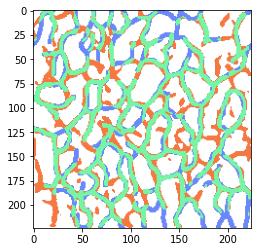

In [ ]:
import matplotlib.pyplot as plt
out=model(test_dataset[5][0].unsqueeze(dim=0).cuda())
plt.imshow((out>0).cpu().detach().numpy().squeeze())

colour_dictionary={
    'white':torch.Tensor([255,255,255]),
    'green':torch.Tensor([118,246,165]),
    'red': torch.Tensor([245,119,65]),
    'blue': torch.Tensor([107,136,250])
}

def visualize_prediction(prediction, label, colour_dictionary):
  '''
  prediction and label are two numpy arrays in two dimensions WxH
  White=TN, Green=TP, RED=FP, BLUE=FN
  '''
  visualization=np.empty(shape=(prediction.shape[0],prediction.shape[1],3))
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      if prediction[i][j]==1 and label[i][j]==1: #TP
        visualization[i,j,:]=colour_dictionary['green']
      if prediction[i][j]==0 and label[i][j]==0: #TN
        visualization[i,j,:]=colour_dictionary['white']
      if prediction[i][j]==0 and label[i][j]==1: #FN
        visualization[i,j,:]=colour_dictionary['blue']
      if prediction[i][j]==1 and label[i][j]==0: #FP
        visualization[i,j,:]=colour_dictionary['red']
  plt.imshow(visualization.astype(np.uint8))

sample=3
out=model(test_dataset[sample][0].unsqueeze(dim=0).cuda())      
visualize_prediction((out>0).cpu().detach().squeeze(), test_dataset[sample][1].squeeze(),colour_dictionary) 

Sweeps autoML

In [ ]:
sweep_config = {
  "name" : "sweep1",
  "method" : "random",
  "parameters" : 
  {
      "optimizer_config" : {
      "values" : ['SGD','Adam']},
   
    "learning_rate" :{
      "values": [0.001,0.01,0.1,1]},

  "encoder_type":{
      "values": ['resnet18','resnet34','resnet50']},
   
  "step_size":{
      "min": 1,
      "max": 8},
   
  "gamma": {
      "min":0.1,
      "max":0.95},
   
   "n_epochs":{
       "min":5,
       "max":30}
    },
  "metric":{
    "name": "validation loss",
    "goal": "minimize"},

  "early_terminate":{
    "type": "hyperband",
    "min_iter": 2}
}

sweep_id = wandb.sweep(sweep_config)
print(wandb.config)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ynj430y5
Sweep URL: https://wandb.ai/emanuelefasce/uncategorized/sweeps/ynj430y5
{'model_type': 'Unet', 'epochs': 2, 'learning_rate': 0.1, 'encoder': 'resnet18', 'optimizer': 'SGD', 'step_size': 5, 'gamma': 0.1, 'number_of_crops_each_image': 1}


In [ ]:
from torch.optim import *
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

def train(config=None):

    with wandb.init(config=config) as run:
        config=wandb.config
        
        optimizer_config=config["optimizer_config"]
        encoder_type=config['encoder_type']
        learning_rate=config["learning_rate"]
        step_size=config["step_size"]
        gamma=config["gamma"]
        n_epochs=config["n_epochs"]

        #Loading the model
        model = smp.Unet(
          encoder_name=encoder_type,       
          encoder_weights="imagenet", 
          in_channels=3,                 
          classes=1)
        model.cuda()
        
        #Loading optimizers
        if optimizer_config=='SGD':
          optimizer=SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        if optimizer_config=='Adam':
          optimizer=Adam(model.parameters(), lr=learning_rate)
        if optimizer_config=='AdamW':
          optimizer=AdamW(model.parameters(), lr=learning_rate)

        scheduler=StepLR(optimizer, step_size=step_size, gamma=gamma)
        lowest_validation_loss=9999

        for epoch in range(1, n_epochs+1,1):

          #Training phase
          model.train()
          training_loss=0
          training_iou=0
          training_samples=0

          for x,y in tqdm(train_dataloader): 
            optimizer.zero_grad()
            out=model(x.cuda())
            myloss=loss(out, y.cuda())

            for out_i,y_i in zip(out,y.cuda()):
              iou=iou_numpy(out_i>0,y_i)
              training_iou+=iou
              training_samples+=1

            myloss.backward()
            optimizer.step()
            training_loss+=myloss.item()
          
          print(f'Epoch #{epoch}, training loss: {training_loss/training_samples}, training iou: {training_iou/training_samples}')
          scheduler.step()

          wandb.log({"training loss": training_loss/training_samples})
          wandb.log({"training iou": training_iou/training_samples})

          #Validation phase
          model.eval()
          validation_loss=0
          validation_iou=0
          validation_samples=0

          for x,y in tqdm(valid_dataloader): 
            out=model(x.cuda())
            myloss=loss(out, y.cuda())

            for out_i,y_i in zip(out,y.cuda()):
              iou=iou_numpy(out_i>0,y_i)
              validation_iou+=iou
              validation_samples+=1

            validation_loss+=myloss.item()

          print(f'Epoch #{epoch}, validation loss: {validation_loss/validation_samples}, validation iou: {validation_iou/validation_samples}')

          if validation_loss/validation_samples<lowest_validation_loss:
            lowest_validation_loss=validation_loss/validation_samples
            torch.save(model,f'{save_model_path}.pth')
            last_epoch_saved=epoch
          
          wandb.log({"training loss": training_loss/training_samples, "validation loss": validation_loss/validation_samples, "epoch":epoch})
          wandb.log({"training iou": training_iou/training_samples, "validation iou": validation_iou/validation_samples, "epoch": epoch})

        print(f'Last epoch saved: {last_epoch_saved}')
        wandb.log({"last epoch saved": last_epoch_saved})
count=5
wandb.agent(sweep_id, function=train, count=count)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: hb8lffhq with config:
wandb: 	encoder_type: resnet34
wandb: 	gamma: 0.9170145585520344
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 28
wandb: 	optimizer_config: AdamW
wandb: 	step_size: 2


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #1, training loss: 0.09122640192508698, training iou: 0.02163751982152462


100%|██████████| 5/5 [01:51<00:00, 22.35s/it]


Epoch #1, validation loss: 1243.7417846679687, validation iou: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #2, training loss: 0.07735197320580482, training iou: 0.0029567615129053593


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


Epoch #2, validation loss: 0.9879174634814263, validation iou: 0.05355026200413704


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #3, training loss: 0.07708778493106365, training iou: 0.009696715511381626


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch #3, validation loss: 0.07490869909524918, validation iou: 0.010060152038931847


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #4, training loss: 0.07638256512582302, training iou: 0.02745014801621437


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch #4, validation loss: 0.07457715123891831, validation iou: 0.03157642483711243


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #5, training loss: 0.07427908554673195, training iou: 0.10953813046216965


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #5, validation loss: 0.07518316805362701, validation iou: 0.21902012825012207


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #6, training loss: 0.07275887876749039, training iou: 0.12870432436466217


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #6, validation loss: 0.08016055375337601, validation iou: 0.32991060614585876


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #7, training loss: 0.07084599360823632, training iou: 0.15517626702785492


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch #7, validation loss: 0.07445603907108307, validation iou: 0.007385671138763428


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #8, training loss: 0.0708051024004817, training iou: 0.1415485292673111


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch #8, validation loss: 0.06840526312589645, validation iou: 0.1821640580892563


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #9, training loss: 0.07054248303174973, training iou: 0.1936386078596115


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #9, validation loss: 0.07780342251062393, validation iou: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #10, training loss: 0.06775256190449, training iou: 0.18466304242610931


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #10, validation loss: 0.26710168123245237, validation iou: 0.14427052438259125


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #11, training loss: 0.06606473382562399, training iou: 0.22672247886657715


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #11, validation loss: 0.07088514268398285, validation iou: 0.2022257149219513


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #12, training loss: 0.06648724656552077, training iou: 0.21837130188941956


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #12, validation loss: 0.08224897384643555, validation iou: 0.06619545072317123


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #13, training loss: 0.06521813310682774, training iou: 0.2673463821411133


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #13, validation loss: 0.07093736082315445, validation iou: 0.22542333602905273


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #14, training loss: 0.0649131864309311, training iou: 0.2538895606994629


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #14, validation loss: 0.0728241965174675, validation iou: 0.09625682979822159


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #15, training loss: 0.06443207655102015, training iou: 0.2549286484718323


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch #15, validation loss: 0.06210107207298279, validation iou: 0.22986315190792084


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #16, training loss: 0.06458912454545498, training iou: 0.26949945092201233


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #16, validation loss: 0.06851298958063126, validation iou: 0.13013681769371033


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #17, training loss: 0.06304310131818056, training iou: 0.28591427206993103


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #17, validation loss: 0.06680266931653023, validation iou: 0.07210938632488251


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #18, training loss: 0.06190376505255699, training iou: 0.31788086891174316


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #18, validation loss: 0.06920994967222213, validation iou: 0.27255961298942566


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #19, training loss: 0.06318779084831476, training iou: 0.2891078293323517


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #19, validation loss: 0.08051407337188721, validation iou: 0.0009972057305276394


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #20, training loss: 0.06312914937734604, training iou: 0.30007869005203247


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #20, validation loss: 0.06539024412631989, validation iou: 0.14271868765354156


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #21, training loss: 0.06196533497422933, training iou: 0.3232547342777252


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #21, validation loss: 0.0730747863650322, validation iou: 0.0041625420562922955


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #22, training loss: 0.060825069434940815, training iou: 0.32011914253234863


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #22, validation loss: 0.07098986580967903, validation iou: 0.25142166018486023


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #23, training loss: 0.06016003116965294, training iou: 0.34320762753486633


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch #23, validation loss: 0.06054663360118866, validation iou: 0.26540836691856384


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #24, training loss: 0.05978500619530678, training iou: 0.3495529890060425


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch #24, validation loss: 0.060453534871339795, validation iou: 0.2750149369239807


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #25, training loss: 0.05904349982738495, training iou: 0.3734692931175232


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #25, validation loss: 0.06689510494470596, validation iou: 0.15348538756370544


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #26, training loss: 0.05975433122366667, training iou: 0.35130080580711365


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #26, validation loss: 0.06695800498127938, validation iou: 0.10127346962690353


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #27, training loss: 0.061911707371473314, training iou: 0.33812007308006287


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #27, validation loss: 0.06662852019071579, validation iou: 0.2407940924167633


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #28, training loss: 0.06011580005288124, training iou: 0.3532125651836395


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch #28, validation loss: 0.06556040197610855, validation iou: 0.13910910487174988
Last epoch saved: 24


training loss,0.06012
_runtime,1885
_timestamp,1625408901
_step,111
training iou,0.35321
validation loss,0.06556
validation iou,0.13911


training loss,█▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training iou,▁▁▁▁▃▃▄▄▅▄▅▅▆▆▆▆▆▇▆▇▇▇▇███▇█
validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation iou,▁▂▁▂▆█▁▅▁▄▅▂▆▃▆▄▃▇▁▄▁▆▇▇▄▃▆▄


wandb: Agent Starting Run: 508ciw0y with config:
wandb: 	encoder_type: resnet50
wandb: 	gamma: 0.2722744720560231
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 22
wandb: 	optimizer_config: SGD
wandb: 	step_size: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #1, training loss: 0.07825203444808722, training iou: 0.05796057730913162


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch #1, validation loss: 0.09405239075422286, validation iou: 0.21507477760314941


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #2, training loss: 0.06491519901901484, training iou: 0.27269503474235535


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #2, validation loss: 0.1980033427476883, validation iou: 0.34844300150871277


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #3, training loss: 0.061949236690998076, training iou: 0.32615724205970764


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch #3, validation loss: 0.057089314609766004, validation iou: 0.292725533246994


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #4, training loss: 0.05875047724694014, training iou: 0.3726596534252167


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #4, validation loss: 0.06183437705039978, validation iou: 0.36815187335014343


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #5, training loss: 0.05779543109238148, training iou: 0.39340004324913025


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch #5, validation loss: 0.05586072951555252, validation iou: 0.2932606339454651


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #6, training loss: 0.05560605376958847, training iou: 0.4053132236003876


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #6, validation loss: 0.06001436412334442, validation iou: 0.3728642463684082


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #7, training loss: 0.05540607087314129, training iou: 0.41842207312583923


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #7, validation loss: 0.06958275213837624, validation iou: 0.24434331059455872


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #8, training loss: 0.05367258004844189, training iou: 0.43845367431640625


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch #8, validation loss: 0.05069990232586861, validation iou: 0.4493207633495331


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #9, training loss: 0.052182207070291045, training iou: 0.45118066668510437


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch #9, validation loss: 0.049075405299663546, validation iou: 0.424683541059494


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #10, training loss: 0.05235829260200262, training iou: 0.46604371070861816


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #10, validation loss: 0.05054102391004563, validation iou: 0.4680619239807129


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #11, training loss: 0.051583525538444516, training iou: 0.46953725814819336


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #11, validation loss: 0.05020317807793617, validation iou: 0.38267451524734497


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #12, training loss: 0.05190028753131628, training iou: 0.46121594309806824


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #12, validation loss: 0.061875137686729434, validation iou: 0.44321107864379883


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #13, training loss: 0.05113503057509661, training iou: 0.4692629873752594


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #13, validation loss: 0.04916199892759323, validation iou: 0.43631163239479065


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #14, training loss: 0.050097863748669626, training iou: 0.484514057636261


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #14, validation loss: 0.05039890334010124, validation iou: 0.4588986933231354


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #15, training loss: 0.048572851531207564, training iou: 0.499993234872818


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch #15, validation loss: 0.04906681254506111, validation iou: 0.4446752667427063


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #16, training loss: 0.04789871498942375, training iou: 0.5052286982536316


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch #16, validation loss: 0.04662766233086586, validation iou: 0.48162227869033813


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #17, training loss: 0.047218856029212476, training iou: 0.516476035118103


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #17, validation loss: 0.04950881600379944, validation iou: 0.4248947203159332


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #18, training loss: 0.04718366060405969, training iou: 0.5197488069534302


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #18, validation loss: 0.053021276742219924, validation iou: 0.45450448989868164


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #19, training loss: 0.046072492562234404, training iou: 0.527969241142273


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #19, validation loss: 0.04808420240879059, validation iou: 0.4884497821331024


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #20, training loss: 0.04533098191022873, training iou: 0.5353185534477234


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #20, validation loss: 0.05124960467219353, validation iou: 0.42808452248573303


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #21, training loss: 0.04444717951118946, training iou: 0.5439772605895996


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #21, validation loss: 0.05468995124101639, validation iou: 0.3985605537891388


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #22, training loss: 0.042560058459639546, training iou: 0.5644625425338745


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch #22, validation loss: 0.08526888191699981, validation iou: 0.2171240895986557
Last epoch saved: 16


training loss,0.04256
_runtime,1155
_timestamp,1625410061
_step,87
training iou,0.56446
validation loss,0.08527
validation iou,0.21712


training loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training iou,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
validation loss,▃█▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃
validation iou,▁▄▃▅▃▅▂▇▆▇▅▇▇▇▇█▆▇█▆▆▁


wandb: Agent Starting Run: gwce9n7m with config:
wandb: 	encoder_type: resnet18
wandb: 	gamma: 0.5795643539340837
wandb: 	learning_rate: 1
wandb: 	n_epochs: 5
wandb: 	optimizer_config: SGD
wandb: 	step_size: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #1, training loss: 0.08094757720828057, training iou: 0.01711100898683071


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch #1, validation loss: 0.2988092839717865, validation iou: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #2, training loss: 0.07388240322470666, training iou: 1.3689337720279582e-05


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch #2, validation loss: 0.07666125148534775, validation iou: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #3, training loss: 0.06905581634491682, training iou: 0.1917879432439804


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #3, validation loss: 0.08191998600959778, validation iou: 0.19012239575386047


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #4, training loss: 0.06682734470814466, training iou: 0.2587527930736542


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch #4, validation loss: 0.06075667962431908, validation iou: 0.32269948720932007


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #5, training loss: 0.06748179569840432, training iou: 0.2397342473268509


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch #5, validation loss: 0.07306053638458251, validation iou: 0.0
Last epoch saved: 4


training loss,0.06748
_runtime,253
_timestamp,1625410319
_step,19
training iou,0.23973
validation loss,0.07306
validation iou,0.0


training loss,█▄▂▁▁
_runtime,▁▁▁▁▃▃▃▃▄▄▅▅▆▆▆▆████
_timestamp,▁▁▁▁▃▃▃▃▄▄▅▅▆▆▆▆████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training iou,▁▁▆█▇
validation loss,█▁▂▁▁
validation iou,▁▁▅█▁


wandb: Agent Starting Run: lkfe77y9 with config:
wandb: 	encoder_type: resnet34
wandb: 	gamma: 0.7798788012113624
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 25
wandb: 	optimizer_config: Adam
wandb: 	step_size: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #1, training loss: 0.08819269649684429, training iou: 0.02269715629518032


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch #1, validation loss: 159.7708953857422, validation iou: 0.2881341874599457


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #2, training loss: 0.07799744121730327, training iou: 0.0009487421484664083


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch #2, validation loss: 0.22777974605560303, validation iou: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #3, training loss: 0.07707536332309246, training iou: 0.0


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch #3, validation loss: 0.07506352066993713, validation iou: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #4, training loss: 0.07668817825615407, training iou: 0.0


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch #4, validation loss: 0.07396129071712494, validation iou: 0.0


 35%|███▌      | 7/20 [00:14<00:26,  2.06s/it]wandb: Ctrl + C detected. Stopping sweep.
